# The K-profile parameterization in `OceanTurb.jl`

Here we demonstrate how to set up a `Model` in `OceanTurb.jl`, set initial conditions and boundary conditions, iterate the model forward, and plot the results.

In [1]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()
using OceanTurb, Printf

@use_pyplot_utils

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Dimensions, constants, and notation

Constants in `OceanTurb` have the default values

In [2]:
c = OceanTurb.Constants()

println("Constants in OceanTurb:")
[ @eval @show $p = c.$(p) for p in propertynames(c) ]

println("\nThese two combinations crop up from time to time:")
@show α*g α*g/(ρ₀*cP)

Constants in OceanTurb:
g = c.g = 9.81
cP = c.cP = 3992.0
ρ₀ = c.ρ₀ = 1035.0
α = c.α = 0.00025
β = c.β = 8.0e-5
f = c.f = 0.0

These two combinations crop up from time to time:
α * g = 0.0024525000000000003
(α * g) / (ρ₀ * cP) = 5.935784612703669e-10


5.935784612703669e-10

# Four "simple flux" initial value problems

We consider four initial value problems with identical initial conditions and differing atmospheric fluxes.
The problems are initialized with zero velocity fields and a linear temperature stratification, so that

$$ U = V = 0 \, , \qquad S = S_0 \, , \quad \text{and} \quad T = T_0 + \gamma z \, . $$

The initial temperature gradient $\gamma$ corresponds to an initial buoyancy frequency $N_0$

$$ N_0^2 = \alpha g \gamma \approx 2.45 \times 10^{-3} \gamma $$

with $\alpha = 2.5 \times 10^{-4} \, \mathrm{C^{-1}}$ 
and $g = 9.81 \, \mathrm{m \, s^{-2}}$.

The four atmospheric flux conditions we consider are 

1. Constant, unstable buoyancy flux $F_b$ with no wind
2. Constant wind stress and velocity flux $F_u$ with no buoyancy forcing
3. Constant velocity flux with unstable buoyancy forcing
4. Constant velocity flux with stable buoyancy forcing

For simplicity we add the flux only to $U$.

To implement these cases we write a function, `simple_flux_model` that sets up the `OceanTurb.KPP` model and also allows us to set arbitrary `parameters`.

In [3]:
function simple_flux_model(; N=10, L=100, Tz=0.01, Fb=1e-8, Fu=0, parameters=KPP.Parameters())
    
    model = KPP.Model(N=N, L=L, parameters=parameters, stepper=:BackwardEuler)

    # Initial condition
    T₀(z) = 20 + Tz*z
    
    # Set T to the function T0(z)
    model.solution.T = T₀

    # Fluxes
    Fθ = Fb / (model.constants.α * model.constants.g)
    model.bcs.U.top = FluxBoundaryCondition(Fu)
    model.bcs.T.top = FluxBoundaryCondition(Fθ)
    model.bcs.T.bottom = GradientBoundaryCondition(Tz)
    
    return model
end

simple_flux_model (generic function with 1 method)

# Domain size and run duration for "simple flux" cases

Next, we determine the size of the domain and the duration of the runs we consider.
To do that, we introduce a bit of boundary layer physics to motivate our choices.

## Introductory physics

Momentum fluxes due to wind stress $\boldsymbol{\tau}$ and buoyancy fluxes $F_b$
are associated with the velocity scales 

$$ \omega_\tau = F_u^{1/2} \, , \qquad \text{and} \qquad \omega_b = | h F_b |^{1/3} \, , $$

where $h$ is the depth of the well-mixed layer that develops at the surface due to turbulent mixing.
These velocity scales correspond to the kinetic and potential energy fluxes
associated with momentum and buoyancy flux, respectively.
In particular, the energy fluxes are the cube of the velocity scales.

The nature of turbulent boundary layer mixing thus depends on whether the 'energy flux ratio'

$$ r \equiv \left ( \frac{\omega_b}{\omega_\tau} \right )^3 = \frac{h |F_b|}{F_u^{3/2}} \, , $$

is greater or less than 1.

## The `simple_flux` cases

The four simple flux cases induce constant atmospheric forcing into an initially linearly stratified fluid.
If we arbitrary pick the atmospheric flux magnitudes

$$ F_b = \pm 5 \times 10^{-8} \, \mathrm{m^2 \, s^{-3}} \, , \qquad \text{and} \qquad F_u = 10^{-4} \, \mathrm{m^2 \, s^{-2}} \, ,$$ 

we find that $r=1$ when 

$$ h = \frac{F_u^{3/2}}{|F_b|} = 20 \, \mathrm{meters} $$

We therefore choose a domain of depth $100$ meters to observe a range of turbulence regimes under mixed atmospheric flux conditions.

## Rate of boundary layer deepening

On dimensional grounds, we expect that in the case of constant, unstable, buoyancy flux
the mixing layer depth increases accoring to

$$ h \sim \sqrt{ \frac{F_b}{N_0^2} t } \, , $$

where $N_0^2$ is the initial buoyancy frequency.
In the case of constant wind stress, on the other hand, the same analysis suggests

$$ h \sim \sqrt{ \frac{F_u}{N_0} t} \, , $$

For simplicity, we pick a weak initial temperature gradient $\gamma = 4.08 \times 10^{-4}$, 
so that $N_0^2 = 10^{-6} \, \mathrm{s^{-2}}$ and $N_0 = 10^{-3} \, \mathrm{s^{-1}}$.

Thus with an unstable buoyancy flux of $F_b = 5 \times 10^{-8} \, \mathrm{m^2 \, s^{-3}}$ and 
velocity flux due to wind stress of $F_u = 10^{-4} \, \mathrm{m^2 \, s^{-2}}$ we find that the boundary layer 
deepens according to

$$ \text{(unstable buoyancy flux)} \quad h \sim 0.22 \, t^{1/2} $$

and 

$$ \text{(wind stress)} \quad h \sim 0.32 \, t^{1/2} $$

A depth of $h=20$ meters is reached after $t \approx 1.1$ hours for wind stress and
$t \approx 2.2$ hours for unstable buoyancy flux, and deepening due to wind stress is twice as fast
as unstable buoyancy forcing.

Below, we show the arthimetic that produces the above calculations.

In [4]:
γ = 4.08e-4 # temperature gradient
Fb = 5e-8 # buoyancy forcing
Fu = 1e-4 # wind stress

@printf "A buoyancy frequency of "
@show N₀ = sqrt(α*g*γ) 

@printf "implies a buoyancy period (in minutes) of\n\n"
@show T = 2π/N₀ / minute

@printf "\nThe scaling factors in boundary layer deepening for buoyancy flux and wind stress are\n\n"
@show sqrt(Fb/N₀^2) sqrt(Fu/N₀) 

@printf "\nThe time (in hours) to reach a depth (in meters) of \n\n"

@show h₀ = Fu^(3/2) / Fb

@printf "\nin each case is\n\n"
@show (h₀^2 * N₀^2/Fb) / hour h₀^2 * N₀/Fu / hour

0;

A buoyancy frequency of N₀ = sqrt(α * g * γ) = 0.0010003099519648897
implies a buoyancy period (in minutes) of

T = ((2π) / N₀) / minute = 104.68730708313034

The scaling factors in boundary layer deepening for buoyancy flux and wind stress are

sqrt(Fb / N₀ ^ 2) = 0.22353751185895174
sqrt(Fu / N₀) = 0.31617876969770803

The time (in hours) to reach a depth (in meters) of 

h₀ = Fu ^ (3 / 2) / Fb = 20.000000000000004

in each case is

((h₀ ^ 2 * N₀ ^ 2) / Fb) / hour = 2.2236000000000007
((h₀ ^ 2 * N₀) / Fu) / hour = 1.1114555021832113


We next define helper functions to run the simple flux model for a few simple parameters:

* Resolution `Δ`
* Time step size `dt`
* Case (1, 2, 3, 4)

In [5]:
Fb = 5e-8
Fu = -1e-4

fluxes = Dict(
    1 => ( Fb,  0),
    2 => (  0, Fu),
    3 => ( Fb, Fu),
    4 => (-Fb, Fu)
)
            
function run_simple_flux_model(case, Δ, dt, parameters=KPP.Parameters())
    Tz = 4.08e-4 # temperature gradient
                
    L = 100 # meters
    N = Int(L/Δ)
                
    tfinal = 4 * hour
    toutput = 10 * minute # output every 10 minutes = > 24 outputs
                
    ntotal = Int(tfinal/dt) # will fail unless dt is a nice number
    ninterm = Int(toutput/dt)
    noutput = Int(ntotal / ninterm)
    
    Fb, Fu = fluxes[case]
        
    model = simple_flux_model(N=N, L=L, Tz=Tz, Fb=Fb, Fu=Fu, parameters=parameters)
                
    h = Float64[]
    t = Float64[]
    U = []
    T = []
                
    for i = 1:noutput      
        iterate!(model, dt, ninterm)
        push!(h, model.state.h)
        push!(t, time(model))
        push!(U, deepcopy(model.solution.U))
        push!(T, deepcopy(model.solution.T))
    end
                
    return U, T, h, t, model
end

run_simple_flux_model (generic function with 2 methods)

Next, we run a few cases and plot the results.

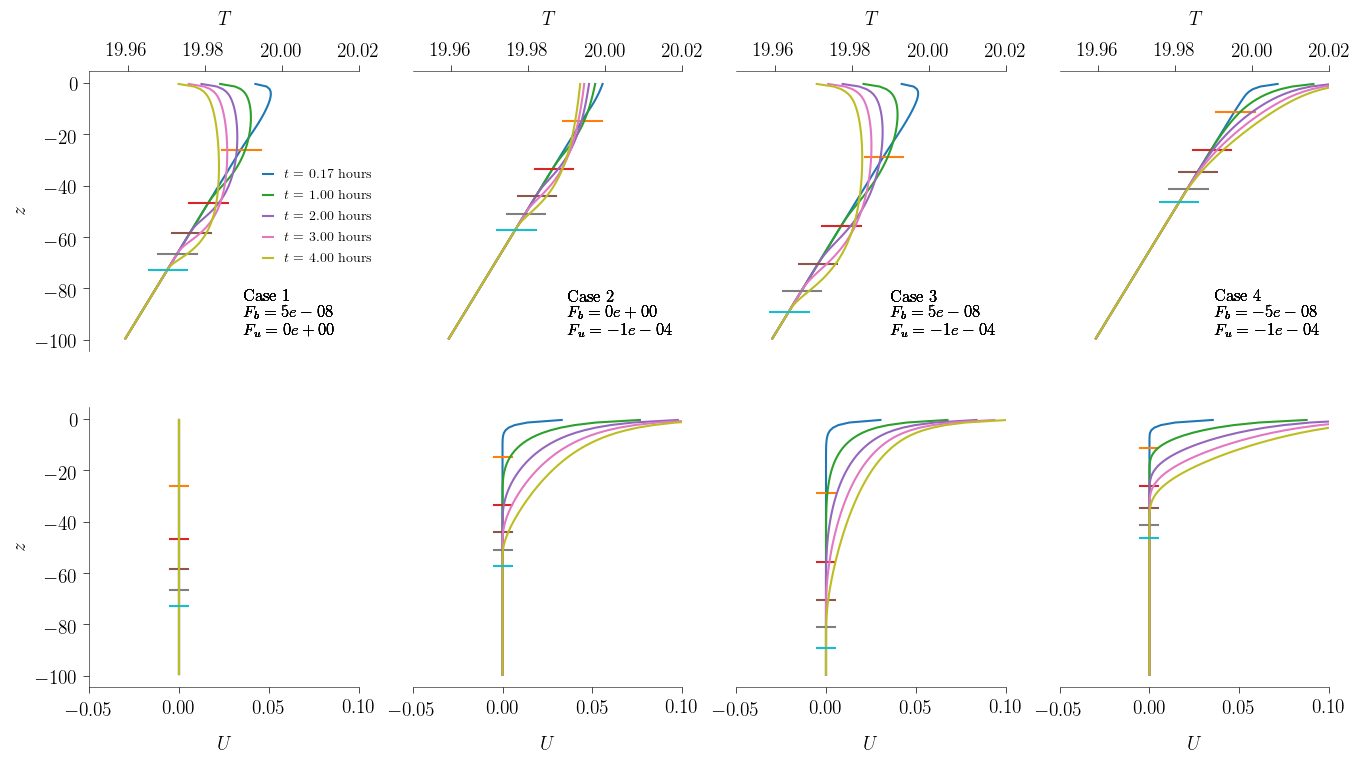

In [6]:
runs = []
for case = 1:4
    push!(runs, run_simple_flux_model(case, 1, minute))
end

function at_depth(T, h)
    ih = searchsortedfirst(T.grid.zc, -h)
    return T[ih]
end

fig, axs = subplots(ncols=4, nrows=2, figsize=(16, 8))

cols, rows = size(axs)
defaultcolors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

font = fontmanager.FontProperties()
font.set_style("normal")
font.set_weight("light")
font.set_size("large")

for j = 1:rows
    for i = 1:cols
        ax = axs[i, j]
        sca(ax)
        
        removespines("right")
        
        if j > 1
            removespines("left")
            ax.tick_params(left=false, labelleft=false)
        else
            ylabel(L"z")
        end
        
        if i == 1
            removespines("bottom")
            ax.tick_params(bottom=false, labelbottom=false, top=true, labeltop=true)
            xlabel(L"T", labelpad=12.0)
            ax.xaxis.set_label_position("top")
        else
            removespines("top")
            xlabel(L"U", labelpad=12.0)
        end  
            
        U, T, h, t, model = runs[j]

        for jout in [1, 6, 12, 18, 24]
            Ui = U[jout]
            Ti = T[jout]
            
            if i == 1                 
                plotlabel = j == 1 ? @sprintf("\$ t \$ = %.2f hours", t[jout]/hour) : ""
                plot(Ti, label=plotlabel)
                plot(at_depth(Ti, h[jout]) .+ 0.005*[-1, 1], -h[jout]*[1, 1], "-")
                xlim(19.95, 20.02)
                
                label = @sprintf("Case %d \n \$ F_b = %.0e\$ \n \$ F_u = %.0e \$", j, fluxes[j][1], fluxes[j][2])
                text(19.99, -90, label, verticalalignment="center", fontproperties=font)
            else                     
                plot(Ui)
                plot(at_depth(Ui, h[jout]) .+ 0.005*[-1, 1], -h[jout]*[1, 1], "-")
                xlim(-0.05, 0.1)
            end
        end
                    
        j == 1 && i == 1 && legend(fontsize="medium", handlelength=0.7, loc="best", bbox_to_anchor=(0.6, 0.7))
    end

end